In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import deque

## Extracting the hand keypoints and storing them in array form


In [ ]:


# Input & output paths
input_root = "path/to/your/dataset"
output_root = "keypoints_dataset"
os.makedirs(output_root, exist_ok=True)

# Mediapipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

def extract_keypoints(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = hands.process(image_rgb)
    if result.multi_hand_landmarks:
        keypoints = []
        for lm in result.multi_hand_landmarks[0].landmark:
            keypoints.extend([lm.x, lm.y, lm.z])
        return keypoints
    else:
        return [0.0] * 63  # No hand detected

# Iterate through dataset
for class_name in tqdm(os.listdir(input_root), desc="Classes"):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path): continue

    output_class_path = os.path.join(output_root, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    for video_folder in tqdm(os.listdir(class_path), desc=f"Processing {class_name}", leave=False):
        video_path = os.path.join(class_path, video_folder)
        if not os.path.isdir(video_path): continue

        keypoint_sequence = []

        # Sort frame files to ensure correct order
        frame_files = sorted(os.listdir(video_path))
        for frame_file in frame_files:
            frame_path = os.path.join(video_path, frame_file)
            image = cv2.imread(frame_path)
            if image is None: continue
            keypoints = extract_keypoints(image)
            keypoint_sequence.append(keypoints)

        # Pad or truncate to 37 frames
        if len(keypoint_sequence) < 37:
            padding = [[0.0] * 63] * (37 - len(keypoint_sequence))
            keypoint_sequence.extend(padding)
        else:
            keypoint_sequence = keypoint_sequence[:37]

        keypoint_sequence = np.array(keypoint_sequence)  # shape: (37, 63)
        np.save(os.path.join(output_class_path, f"{video_folder}.npy"), keypoint_sequence)
hands.close()


Classes: 100%|██████████| 6/6 [20:10<00:00, 201.81s/it]


## checking gpu availability

In [ ]:

# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121)
import torch
print(torch.cuda.is_available())       # Should be True
print(torch.cuda.get_device_name(0))   # Should show your GPU

True
NVIDIA GeForce RTX 4060 Laptop GPU


## Creating keypoint dataset

In [3]:
class KeypointDataset(Dataset):
    def __init__(self, root_dir, label_map, transform=None):
        self.root_dir = root_dir
        self.label_map = label_map
        self.transform = transform
        self.samples = []

        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path): continue
            label = label_map[class_name]
            for file_name in os.listdir(class_path):
                if file_name.endswith(".npy"):
                    self.samples.append((os.path.join(class_path, file_name), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        data = np.load(file_path)  # shape: (37, 63)
        if self.transform:
            data = self.transform(data)
        data = torch.tensor(data, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return data, label


## Splitting dataset into train ,test and valid

In [ ]:
# Set path and label mapping
root_dir = "keypoints_dataset"
#change the labels as per your choosen categories
label_map = {
    "Sliding_Two_Fingers_Down": 0,
    "Sliding_Two_Fingers_Left": 1,
    "Sliding_Two_Fingers_Right": 2,
    "Sliding_Two_Fingers_Up": 3,
    "No_gesture": 4,
    "Zooming_In_With_Full_Hand": 5
}

# Create full dataset
dataset = KeypointDataset(root_dir, label_map)

# Split into train/val/test (e.g., 70/15/15)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Create dataloaders
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


Checking the max no of labels(not necessary)

In [5]:
# checking the labels
for inputs, labels in train_loader:
    print("Sample labels:", labels[:10])
    print("Max label:", labels.max().item())
    print("Min label:", labels.min().item())
    break

Sample labels: tensor([3, 2, 1, 0, 0, 3, 3, 5, 5, 4])
Max label: 5
Min label: 0


## Creating model (defining the lstm layers)

In [ ]:

class GestureLSTM(nn.Module):
    def __init__(self, input_size=63, hidden_size=128, num_layers=2, num_classes=6):  #edit number of classes as per selected categories
        super(GestureLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out




In [7]:
model = GestureLSTM().to("cuda")  # Use .to("cuda") or .to("cpu") depending on your setup

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Training the model

In [9]:

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Hyperparameters
num_epochs = 200
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    # Print results
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved!")



Epoch [1/200] Train Loss: 7.5602, Train Acc: 92.02% | Val Loss: 4.3293, Val Acc: 82.22%
✅ Best model saved!
Epoch [2/200] Train Loss: 7.0842, Train Acc: 92.50% | Val Loss: 4.1914, Val Acc: 81.67%
Epoch [3/200] Train Loss: 7.3526, Train Acc: 92.02% | Val Loss: 4.1046, Val Acc: 81.67%
Epoch [4/200] Train Loss: 7.0550, Train Acc: 92.02% | Val Loss: 4.2080, Val Acc: 80.56%
Epoch [5/200] Train Loss: 7.4888, Train Acc: 92.50% | Val Loss: 4.4518, Val Acc: 82.22%
Epoch [6/200] Train Loss: 7.2086, Train Acc: 92.62% | Val Loss: 4.5604, Val Acc: 81.67%
Epoch [7/200] Train Loss: 6.6052, Train Acc: 93.45% | Val Loss: 4.5486, Val Acc: 83.33%
✅ Best model saved!
Epoch [8/200] Train Loss: 6.6417, Train Acc: 93.21% | Val Loss: 4.5182, Val Acc: 82.22%
Epoch [9/200] Train Loss: 6.4040, Train Acc: 93.33% | Val Loss: 4.1945, Val Acc: 82.78%
Epoch [10/200] Train Loss: 6.5074, Train Acc: 93.45% | Val Loss: 4.3128, Val Acc: 82.22%
Epoch [11/200] Train Loss: 6.6364, Train Acc: 93.45% | Val Loss: 4.1716, Val Ac

In [10]:
# Load best model weights
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


  model.load_state_dict(torch.load("best_model.pth"))


GestureLSTM(
  (lstm): LSTM(63, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

## Model Evaluation

In [11]:

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Class names (replace with your actual class folder names in correct order)
class_names = ['Swiping_Two_Fingers_Down', 'Swiping_Two_Fingers_Left', 'Swiping_Two_Fingers_Right', 'Swiping_Two_Fingers_Up','No_gesture','Zooming_In_With_Full_Hand']

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))


                           precision    recall  f1-score   support

 Swiping_Two_Fingers_Down       0.91      0.68      0.78        31
 Swiping_Two_Fingers_Left       0.61      0.81      0.70        27
Swiping_Two_Fingers_Right       0.82      0.58      0.68        24
   Swiping_Two_Fingers_Up       0.83      0.69      0.75        29
               No_gesture       0.60      0.94      0.73        32
Zooming_In_With_Full_Hand       1.00      0.81      0.90        37

                 accuracy                           0.76       180
                macro avg       0.80      0.75      0.76       180
             weighted avg       0.81      0.76      0.77       180



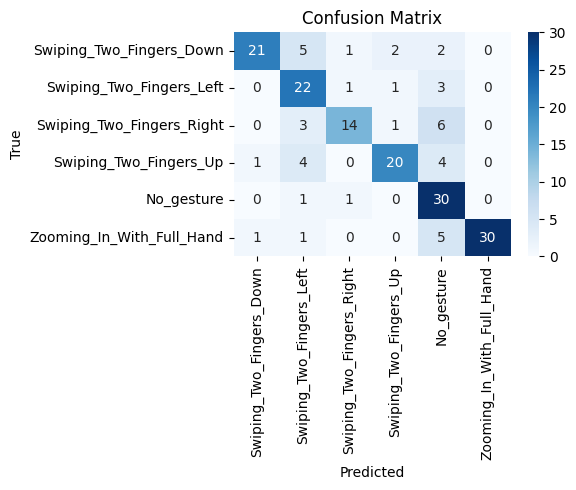

In [12]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


## **Making Inferences**

In [14]:
import cv2
import mediapipe as mp
import numpy as np
import torch
from collections import deque
import time


# Load model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

# Your gesture classes
class_names = ['Swiping_Two_Fingers_Down', 'Swiping_Two_Fingers_Left', 'Swiping_Two_Fingers_Right', 'Swiping_Two_Fingers_Up','No_gesture','Zooming_In_With_Full_Hand']

# MediaPipe setup
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7)

# Video and sequence setup
cap = cv2.VideoCapture(0)
seq_length = 37
keypoint_seq = deque(maxlen=seq_length)

# FPS calculation
prev_time = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Flip and convert to RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = hands.process(image)
    image.flags.writeable = True

    keypoints = np.zeros((21, 3))  # Fallback if no hand detected

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            for i, lm in enumerate(hand_landmarks.landmark):
                keypoints[i] = [lm.x, lm.y, lm.z]
            # Draw hand landmarks
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Save current keypoints to sequence
    keypoint_seq.append(keypoints.flatten())

    # Run inference only if sequence is ready
    if len(keypoint_seq) == seq_length:
        sequence_array = np.array(keypoint_seq)
        input_tensor = torch.tensor(sequence_array, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 37, 63)

        with torch.no_grad():
            output = model(input_tensor)
            probs = torch.softmax(output, dim=1)
            max_prob, predicted = torch.max(probs, 1)

            if max_prob.item() < 0.6:
                label = "No Gesture"
                display_text = f"Gesture: {label}"
            else:
                label = class_names[predicted.item()]
                confidence = max_prob.item() * 100
                display_text = f"{label} ({confidence:.1f}%)"

        # Display result
        cv2.putText(frame, display_text, (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # FPS
    curr_time = time.time()
    fps = 1 / (curr_time - prev_time)
    prev_time = curr_time
    cv2.putText(frame, f"FPS: {int(fps)}", (10, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Show video
    cv2.imshow("Real-Time Hand Gesture Recognition", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
cv2.destroyAllWindows()


  model.load_state_dict(torch.load("best_model.pth", map_location=device))
